In [1]:
import sys
!{sys.executable} -m pip uninstall -y unwrap

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1


In [4]:
!{sys.executable} -m pip install --upgrade --no-deps git+https://github.com/jgraving/unwrap

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jgraving/unwrap to /tmp/pip-req-build-ihmzgmdj
  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap /tmp/pip-req-build-ihmzgmdj
  Resolved https://github.com/jgraving/unwrap to commit 9567136cb65fe506c37f629d43639bcbb06781c0
  Preparing metadata (setup.py) ... done
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=11723 sha256=16dde25bb20a76969c77aa527c9921f7bc7139487941dff0f0ca75c3253ac2dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-b3xktxzf/wheels/2d/84/50/d9d5015af0946ca454640609d86c9175df59e17f1a39b13349
Successfully built unwrap

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
# import numpy as np
# import pandas as pd
# import bambi as bmb
# import arviz as az
# import matplotlib.pyplot as plt

# from unwrap.link.numpy import inverse_softplus
# from unwrap.prior import CircularUniformPrior
# from unwrap.link.bambi import LINKS

# # -------------------------
# # Prepare Data and Save to Parquet (run once)
# # -------------------------
# csv_filepath = '/media/herd_hover/circular_stats_data/zebra_bearings.csv'
# parquet_filepath = 'zebra_bearings_blocks.parquet'

# df = pd.read_csv(csv_filepath, index_col=0)

# # Map original pre_scare (assumed 1=pre, 0=post) to neutral labels
# df["Condition"] = np.where(df["pre_scare"].astype(int) == 1, "pre-approach", "post-approach")
# df["Condition"] = pd.Categorical(
#     df["Condition"],
#     categories=["pre-approach", "post-approach"],
#     ordered=True,
# )

# block_size = 300

# # Group by track and condition (neutral)
# groups = df.groupby(["track_number", "Condition"])

# rows = []
# for (track, cond), group in groups:
#     blocks = [group.iloc[i:i+block_size] for i in range(0, len(group), block_size)]
#     for block in blocks:
#         if len(block) < block_size:
#             continue
#         mean_x = np.mean(np.cos(np.deg2rad(block["compass_bearing"])))
#         mean_y = np.mean(np.sin(np.deg2rad(block["compass_bearing"])))
#         angle = np.arctan2(mean_y, mean_x)
#         rows.append({
#             "Track": track,
#             "Observation": block["observation"].iloc[0],
#             "Condition": cond,
#             "HeadingRadians": angle,
#         })

# df_blocks = pd.DataFrame(rows)

# # Optional numeric convenience flag
# df_blocks["PostStimulus"] = (df_blocks["Condition"] == "post-approach").astype(int)

# # Keep only tracks that have both conditions
# track_counts = df_blocks.groupby("Track")["Condition"].nunique()
# valid_tracks = track_counts[track_counts == 2].index
# df_blocks = df_blocks[df_blocks["Track"].isin(valid_tracks)]

# # Optional: subset specific observations
# df_blocks = df_blocks[df_blocks["Track"].str.contains("observation088", na=False)]

# # ---- Save preprocessed / filtered data to Parquet ----
# df_blocks.to_parquet(parquet_filepath, index=False)
# print(f"Saved preprocessed data to {parquet_filepath}")


/tmp/ipykernel_612635/3499611346.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby(["track_number", "Condition"])


Saved preprocessed data to zebra_bearings_blocks.parquet


In [2]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior
from unwrap.link.bambi import LINKS

# -------------------------
# Load Preprocessed Data from Parquet
# -------------------------
parquet_filepath = 'zebra_bearings_blocks.parquet'
df_blocks = pd.read_parquet(parquet_filepath)

# If you want to be explicit about categories (optional, usually preserved in Parquet):
df_blocks["Condition"] = pd.Categorical(
    df_blocks["Condition"],
    categories=["pre-approach", "post-approach"],
    ordered=True,
)

print(df_blocks.head())


              Track     Observation     Condition  HeadingRadians  \
0  observation088-0  observation088  pre-approach        1.324933   
1  observation088-0  observation088  pre-approach        1.455568   
2  observation088-0  observation088  pre-approach        1.578286   
3  observation088-0  observation088  pre-approach        1.412140   
4  observation088-0  observation088  pre-approach        1.778967   

   PostStimulus  
0             0  
1             0  
2             0  
3             0  
4             0  


In [3]:
df_blocks

,Track,Observation,Condition,HeadingRadians,PostStimulus
0,observation088-0,observation088,pre-approach,1.324933,0
1,observation088-0,observation088,pre-approach,1.455568,0
2,observation088-0,observation088,pre-approach,1.578286,0
3,observation088-0,observation088,pre-approach,1.412140,0
4,observation088-0,observation088,pre-approach,1.778967,0
...,...,...,...,...,...
5412,observation088-9,observation088,post-approach,0.590454,1
5413,observation088-9,observation088,post-approach,0.681380,1
5414,observation088-9,observation088,post-approach,1.071873,1
5415,observation088-9,observation088,post-approach,1.190802,1


In [4]:
df_blocks["Track"].nunique()

18

In [5]:
# -------------------------
# Bambi Circular Model (neutral wording)
# -------------------------
formula = bmb.Formula(
    # Mean Angle (mu) submodel
    "HeadingRadians ~ PostStimulus + (1 + PostStimulus | Track)",
    # Concentration (kappa) submodel
    "kappa ~ PostStimulus + (1 + PostStimulus | Track)",
)

priors = {
    # Angle (mu) part
    "Intercept": bmb.Prior("VonMises", mu=0, kappa=1e-6),   # ~uniform baseline on mean direction
    "PostStimulus": bmb.Prior("VonMises", mu=0, kappa=2.0),  # mild effect prior

    # Random intercept and slope on the angle
    "1|Track": bmb.Prior(
        "VonMises",
        mu=0,
        kappa=bmb.Prior("LogNormal", mu=np.log(30.0), sigma=0.5)
    ),
    "PostStimulus|Track": bmb.Prior(
        "VonMises",
        mu=0,
        kappa=bmb.Prior("LogNormal", mu=np.log(30.0), sigma=0.5)
    ),

    # kappa (concentration) submodel
    "kappa": {
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1.0),
        "PostStimulus": bmb.Prior("Normal", mu=0, sigma=2.0),
        "1|Track": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.0)),
        "PostStimulus|Track": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("HalfNormal", sigma=2.0)),
    },
}

model = bmb.Model(
    formula,
    df_blocks,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["circ_mod"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model)

idata = model.fit(tune=2000, target_accept=0.8)


       Formula: HeadingRadians ~ PostStimulus + (1 + PostStimulus | Track)
                kappa ~ PostStimulus + (1 + PostStimulus | Track)
        Family: vonmises
          Link: mu = circ_mod
                kappa = softplus
  Observations: 5417
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ VonMises(mu: 0.0, kappa: 0.0)
            PostStimulus ~ VonMises(mu: 0.0, kappa: 2.0)
        
        Group-level effects
            1|Track ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.5))
            PostStimulus|Track ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.5))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
            kappa_PostStimulus ~ Normal(mu: 0.0, sigma: 2.0)
        
        Group-level effects
            kappa_1|Track ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.0))
            kappa_PostStimulus|Track ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 2.0

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, PostStimulus, 1|Track_kappa, 1|Track, PostStimulus|Track_kappa, PostStimulus|Track, kappa_Intercept, kappa_PostStimulus, kappa_1|Track_sigma, kappa_1|Track_offset, kappa_PostStimulus|Track_sigma, kappa_PostStimulus|Track_offset]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 263 seconds.


In [6]:
import arviz as az

In [7]:
summary_df = az.summary(idata, circ_var_names=["Intercept", "PostStimulus", "1|Track"])

In [8]:
summary_df[(summary_df["ess_bulk"]<400) | summary_df["r_hat"]>1.01]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns 

# ============================================================
# Helper functions
# ============================================================
def softplus(x):
    return np.log1p(np.exp(-np.abs(x))) + np.maximum(x, 0.0)

def circ_mod(x):
    # wrap to (-pi, pi]
    return (x + np.pi) % (2*np.pi) - np.pi

def wrap_0_2pi(x):
    return x % (2*np.pi)

def circ_mean(a, axis=None):
    a = np.asarray(a)
    s = np.sin(a).mean(axis=axis)
    c = np.cos(a).mean(axis=axis)
    return (np.arctan2(s, c)) % (2*np.pi)

def circ_hdi(samples, prob=0.95):
    """Smallest arc on [0, 2π) containing `prob` mass."""
    a = np.sort(samples % (2*np.pi))
    n = len(a)
    k = int(np.ceil(prob * n))
    a_ext = np.concatenate([a, a + 2*np.pi])
    spans = a_ext[k-1:n + k-1] - a
    j = np.argmin(spans)
    low = a[j]
    high = (a_ext[j + k - 1]) % (2*np.pi)
    return low, high

def as_samples(da):
    """Flatten xarray (chain, draw, *levels) into (S, *levels)."""
    vals = da.values
    if vals.ndim == 2:  # (chain, draw)
        c, d = vals.shape
        return vals.reshape(c * d)
    elif vals.ndim == 1:
        return vals
    elif vals.ndim == 3:  # (chain, draw, level)
        c, d, L = vals.shape
        return vals.reshape(c * d, L)
    else:
        raise ValueError(f"Unexpected shape {vals.shape}")

def circ_mean_series(a):
    a = np.asarray(a)
    if a.size == 0:
        return np.nan
    return circ_mean(wrap_0_2pi(a))

def arc_width(a, b):
    return (b - a) % (2 * np.pi)

# ============================================================
# Posterior extraction & design grid
# ============================================================
post = idata.posterior  # assumes `idata` already exists

# fixed effects (mu)
mu_intercept_name = "Intercept"
mu_post_name = "PostStimulus" if "PostStimulus" in post.data_vars else None

# group effect for mu (random intercept per Track)
mu_g_name = None
for v in post.data_vars:
    if ("|Track" in v) and (not v.startswith("kappa_")) and ("PostStimulus|Track" not in v):
        mu_g_name = v
        break

# random slope for PostStimulus by Track for mu
mu_g_post_name = None
for v in post.data_vars:
    if ("PostStimulus|Track" in v) and (not v.startswith("kappa_")):
        mu_g_post_name = v
        break

# fixed effects (kappa)
k_intercept_name = "kappa_Intercept" if "kappa_Intercept" in post.data_vars else None
k_post_name = "kappa_PostStimulus" if "kappa_PostStimulus" in post.data_vars else None

# group effect for kappa (random intercept)
k_g_name = None
for v in post.data_vars:
    if v.startswith("kappa_") and ("|Track" in v) and ("PostStimulus|Track" not in v):
        k_g_name = v
        break

# random slope for PostStimulus by Track for kappa
k_g_post_name = None
for v in post.data_vars:
    if v.startswith("kappa_") and ("PostStimulus|Track" in v):
        k_g_post_name = v
        break

# sanity checks
if mu_intercept_name not in post:
    raise RuntimeError("Could not find mu Intercept in posterior.")
if (k_intercept_name is None) or (k_intercept_name not in post):
    raise RuntimeError("Could not find kappa_Intercept in posterior.")

# Tracks and grid: each Track × {pre (0), post (1)}
tracks = np.sort(df_blocks["Track"].unique())
nT = len(tracks)

grid = pd.DataFrame({
    "PostStimulus": np.repeat([0, 1], nT),
    "Track":        np.tile(tracks, 2),
})

idx_pre  = np.arange(0, nT)
idx_post = np.arange(nT, 2 * nT)

# ============================================================
# Build linear predictors η_mu, η_kappa per posterior sample
# ============================================================
S = post.sizes["chain"] * post.sizes["draw"]
eta_mu   = np.zeros((S, 2 * nT))
eta_kapp = np.zeros((S, 2 * nT))

# intercepts
eta_mu   += as_samples(post[mu_intercept_name])[:, None]
eta_kapp += as_samples(post[k_intercept_name])[:, None]

# fixed effect PostStimulus
if mu_post_name is not None:
    b = as_samples(post[mu_post_name])  # (S,)
    eta_mu[:, idx_post] += b[:, None]
if k_post_name is not None:
    bk = as_samples(post[k_post_name])
    eta_kapp[:, idx_post] += bk[:, None]

# random intercepts per Track for mu
if mu_g_name is not None:
    mu_g = as_samples(post[mu_g_name])  # (S, L)
    coord_name = [cn for cn in post[mu_g_name].coords if cn not in ("chain", "draw")][0]
    levels = np.array(post[mu_g_name][coord_name].values).astype(str)
    level_idx = {lev: i for i, lev in enumerate(levels)}
    miss = [t for t in tracks if t not in level_idx]
    if miss:
        raise RuntimeError(f"Tracks missing in posterior RE for mu: {miss}")
    for j, t in enumerate(tracks):
        eta_mu[:, j]       += mu_g[:, level_idx[t]]   # pre row
        eta_mu[:, nT + j]  += mu_g[:, level_idx[t]]   # post row

# random slope PostStimulus|Track for mu (post rows only)
if mu_g_post_name is not None:
    mu_g_post = as_samples(post[mu_g_post_name])  # (S, L)
    coord_name_mu_post = [cn for cn in post[mu_g_post_name].coords
                          if cn not in ("chain", "draw")][0]
    levels_mu_post = np.array(post[mu_g_post_name][coord_name_mu_post].values).astype(str)
    level_idx_mu_post = {lev: i for i, lev in enumerate(levels_mu_post)}
    miss_mu_post = [t for t in tracks if t not in level_idx_mu_post]
    if miss_mu_post:
        raise RuntimeError(f"Tracks missing in mu PostStimulus|Track RE: {miss_mu_post}")
    for j, t in enumerate(tracks):
        eta_mu[:, nT + j] += mu_g_post[:, level_idx_mu_post[t]]

# random intercepts per Track for kappa
if k_g_name is not None:
    kg = as_samples(post[k_g_name])  # (S, L)
    coord_name_k = [cn for cn in post[k_g_name].coords if cn not in ("chain", "draw")][0]
    levels_k = np.array(post[k_g_name][coord_name_k].values).astype(str)
    level_idx_k = {lev: i for i, lev in enumerate(levels_k)}
    missk = [t for t in tracks if t not in level_idx_k]
    if missk:
        raise RuntimeError(f"Tracks missing in posterior RE for kappa: {missk}")
    for j, t in enumerate(tracks):
        eta_kapp[:, j]      += kg[:, level_idx_k[t]]
        eta_kapp[:, nT + j] += kg[:, level_idx_k[t]]

# random slope kappa_PostStimulus|Track (post rows only)
if k_g_post_name is not None:
    kg_post = as_samples(post[k_g_post_name])  # (S, L)
    coord_name_kg_post = [cn for cn in post[k_g_post_name].coords
                          if cn not in ("chain", "draw")][0]
    levels_kg_post = np.array(post[k_g_post_name][coord_name_kg_post].values).astype(str)
    level_idx_kg_post = {lev: i for i, lev in enumerate(levels_kg_post)}
    misskg_post = [t for t in tracks if t not in level_idx_kg_post]
    if misskg_post:
        raise RuntimeError(f"Tracks missing in kappa PostStimulus|Track RE: {misskg_post}")
    for j, t in enumerate(tracks):
        eta_kapp[:, nT + j] += kg_post[:, level_idx_kg_post[t]]

# ============================================================
# Apply links
# ============================================================
mu    = circ_mod(eta_mu)     # (-π, π]
kappa = softplus(eta_kapp)   # > 0


/tmp/ipykernel_612635/227093662.py:349: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved figure to: figures/zebra_main_summary.pdf


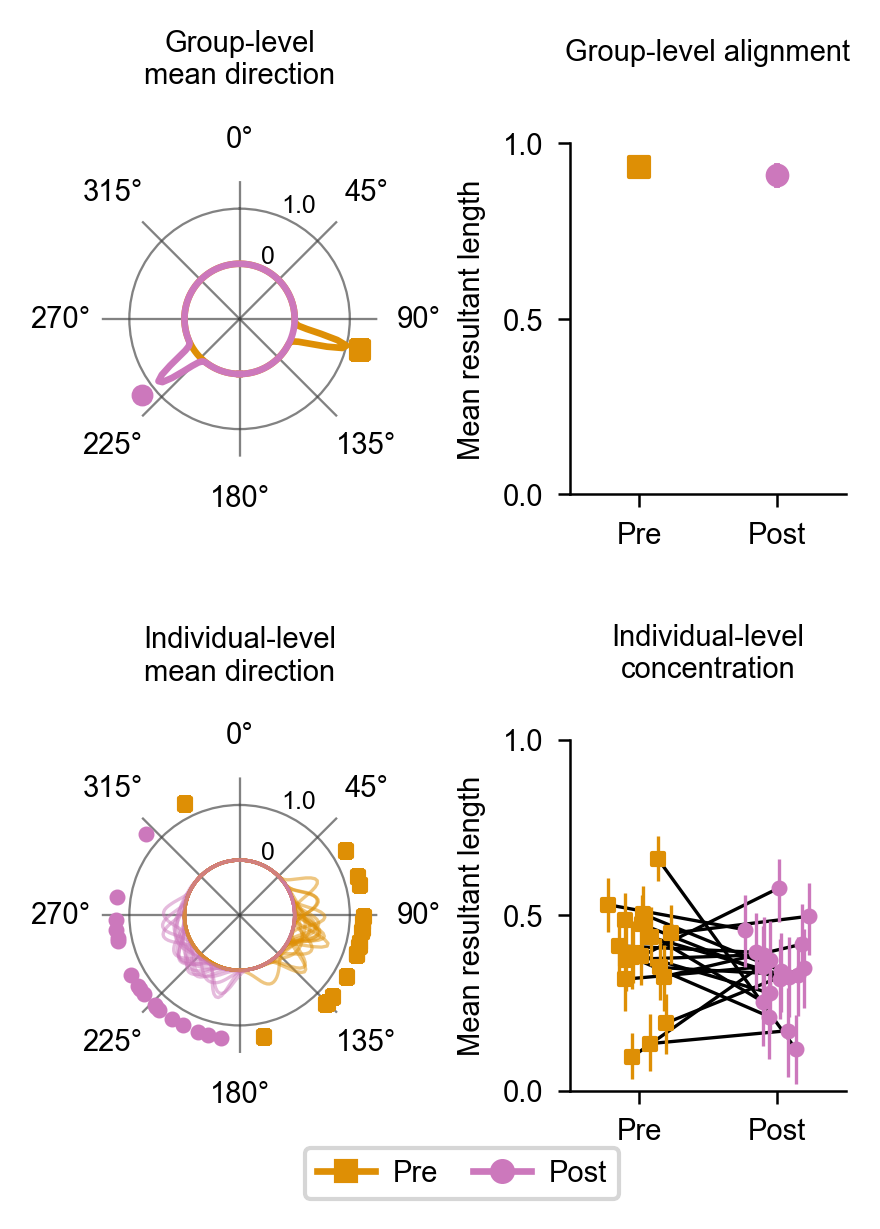

In [18]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import circmean, vonmises
from scipy.special import i0, i1
import seaborn as sns  # only for colorblind palette
import os
# ============================================================
# Aesthetics (match your other figures)
# ============================================================
DPI = 300
AX_LW   = 0.6
TICK_W  = 0.6
TICK_L  = 3
FONT_SZ = 7

mpl.rcParams.update({
    "figure.dpi": DPI,
    "savefig.dpi": DPI,
    "font.size": FONT_SZ,
    "axes.labelsize": FONT_SZ,
    "axes.titlesize": FONT_SZ,
    "legend.fontsize": FONT_SZ,
    "xtick.labelsize": FONT_SZ,
    "ytick.labelsize": FONT_SZ,
    "font.family": "Arial",
    "axes.linewidth": AX_LW,
    "xtick.major.width": TICK_W,
    "ytick.major.width": TICK_W,
    "xtick.major.size": TICK_L,
    "ytick.major.size": TICK_L,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

_cb = sns.color_palette("colorblind")
PRE_COLOR  = _cb[1]  # orange
POST_COLOR = _cb[4]  # purple

# --- NEW: marker scheme (minimal change) ---
PRE_MARK  = "s"   # square
POST_MARK = "o"   # circle

def _restore_ticks(ax):
    ax.tick_params(
        axis="both", which="both",
        direction="out",
        bottom=True, top=False, left=True, right=False,
        length=TICK_L, width=TICK_W
    )
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")

def _despine(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    for s in ("left", "bottom"):
        ax.spines[s].set_linewidth(AX_LW)
    _restore_ticks(ax)

# ============================================================
# Indices
# ============================================================
tracks = np.sort(df_blocks["Track"].unique())
nT     = len(tracks)
idx_pre  = np.arange(0, nT)
idx_post = np.arange(nT, 2 * nT)
S = mu.shape[0]

# ============================================================
# Helpers
# ============================================================
def linear_hdi(samples, prob=0.95):
    s = np.sort(np.asarray(samples, float))
    n = s.size
    if n == 0:
        return np.nan, np.nan
    k = int(np.ceil(prob * n))
    spans = s[k-1:] - s[:n-k+1]
    j = int(np.argmin(spans))
    return float(s[j]), float(s[j + k - 1])

def resultant_length(a, axis=-1):
    a = np.asarray(a)
    return np.sqrt(np.mean(np.cos(a), axis=axis)**2 +
                   np.mean(np.sin(a), axis=axis)**2)

# ============================================================
# GROUP-LEVEL mean direction per draw (your "population level")
# ============================================================
# mu is (-pi, pi]; wrap before averaging
pre_mu_draw  = circ_mean(wrap_0_2pi(mu[:, idx_pre]),  axis=1)   # (S,)
post_mu_draw = circ_mean(wrap_0_2pi(mu[:, idx_post]), axis=1)   # (S,)

mu_group_pre  = circ_mod(pre_mu_draw)   # (-pi, pi]
mu_group_post = circ_mod(post_mu_draw)

# Group-level KDEs (von Mises kernel density over posterior draws)
theta = np.linspace(-np.pi, np.pi, 200)
kappa_bw_group = 500

kde_mu_group_pre = np.mean(
    vonmises.pdf(theta[None, :], kappa=kappa_bw_group, loc=mu_group_pre[:, None]),
    axis=0
)
kde_mu_group_post = np.mean(
    vonmises.pdf(theta[None, :], kappa=kappa_bw_group, loc=mu_group_post[:, None]),
    axis=0
)

# Group alignment = R of individual mean directions (posterior, per draw)
# (This is the same statistic you had; you’re just renaming it "group alignment")
mu_ind_pre  = circ_mod(mu[:, idx_pre])    # (S, nT)
mu_ind_post = circ_mod(mu[:, idx_post])   # (S, nT)

R_group_pre_draw  = resultant_length(mu_ind_pre,  axis=1)  # (S,)
R_group_post_draw = resultant_length(mu_ind_post, axis=1)  # (S,)

# ============================================================
# INDIVIDUAL-LEVEL concentration: convert kappa -> mean resultant length
# ============================================================
kappa_pre  = kappa[:, idx_pre]   # (S, nT)
kappa_post = kappa[:, idx_post]  # (S, nT)

R_ind_pre_samples  = i1(kappa_pre)  / i0(kappa_pre)   # (S, nT)
R_ind_post_samples = i1(kappa_post) / i0(kappa_post)  # (S, nT)

R_ind_pre_mean  = R_ind_pre_samples.mean(axis=0)
R_ind_post_mean = R_ind_post_samples.mean(axis=0)

R_ind_pre_hdi  = np.array([linear_hdi(R_ind_pre_samples[:, j],  prob=0.95) for j in range(nT)])
R_ind_post_hdi = np.array([linear_hdi(R_ind_post_samples[:, j], prob=0.95) for j in range(nT)])

# ============================================================
# Empirical individual means (optional dots on individual polar)
# ============================================================
emp_mu_pre = []
emp_mu_post = []
for t in tracks:
    d_t = df_blocks[df_blocks["Track"] == t]
    h_pre  = d_t.loc[d_t["PostStimulus"] == 0, "HeadingRadians"].dropna().values
    h_post = d_t.loc[d_t["PostStimulus"] == 1, "HeadingRadians"].dropna().values
    m_pre  = np.nan if h_pre.size  == 0 else circmean(h_pre,  high=np.pi, low=-np.pi)
    m_post = np.nan if h_post.size == 0 else circmean(h_post, high=np.pi, low=-np.pi)
    emp_mu_pre.append(m_pre)
    emp_mu_post.append(m_post)
emp_mu_pre = np.array(emp_mu_pre)
emp_mu_post = np.array(emp_mu_post)

# ============================================================
# INDIVIDUAL-LEVEL KDEs for mu (thin curves per individual)
# ============================================================
kappa_bw_ind = 300
kde_mu_ind_pre  = np.zeros((nT, theta.size))
kde_mu_ind_post = np.zeros((nT, theta.size))
for j in range(nT):
    kde_mu_ind_pre[j] = np.mean(
        vonmises.pdf(theta[None, :], kappa=kappa_bw_ind, loc=mu_ind_pre[:, j][:, None]),
        axis=0
    )
    kde_mu_ind_post[j] = np.mean(
        vonmises.pdf(theta[None, :], kappa=kappa_bw_ind, loc=mu_ind_post[:, j][:, None]),
        axis=0
    )

# ============================================================
# Shared scaling for polar densities
# We want: show only "0" and "1.0" density ticks, and points just outside 1.0.
# So map KDE -> r in [1.0, 2.0], but label ticks as 0 and 1.0.
# ============================================================
max_kde = max(
    kde_mu_group_pre.max(), kde_mu_group_post.max(),
    kde_mu_ind_pre.max(), kde_mu_ind_post.max()
)

def scale_kde_to_unit(kde):
    return 1.0 + (kde / (max_kde + 1e-12))  # 1..2

r_group_pre  = scale_kde_to_unit(kde_mu_group_pre)
r_group_post = scale_kde_to_unit(kde_mu_group_post)
r_ind_pre    = scale_kde_to_unit(kde_mu_ind_pre)
r_ind_post   = scale_kde_to_unit(kde_mu_ind_post)

r_dot = 2.25     # "just past 1.0 density" (since 1.0 density == r=2 in this scheme)
rmax  = 2.5

# ============================================================
# Figure layout: 2x2
#   (0,0) Group mean direction (polar)
#   (0,1) Group alignment (vertical; Pre above Post)
#   (1,0) Individual mean directions (polar)
#   (1,1) Individual concentration (paired + HDI)
# ============================================================
FIG_W, FIG_H = 3.2, 4.1
fig = plt.figure(figsize=(FIG_W, FIG_H), dpi=DPI)
gs  = fig.add_gridspec(2, 2, wspace=0.7, hspace=0.70)  # was 0.50

ax_mu_group = fig.add_subplot(gs[0, 0], projection="polar")
ax_R_group  = fig.add_subplot(gs[0, 1])
ax_mu_ind   = fig.add_subplot(gs[1, 0], projection="polar")
ax_R_ind    = fig.add_subplot(gs[1, 1])

# ---- polar formatting (remove outside circle + show only 0 and 1.0 density)
def style_polar(ax):
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlim(0, rmax)

    ax.set_rticks([1.0, 2.0])
    ax.set_yticklabels(["0", "1.0"], color="black")

    # Darker grid (circles + spokes)
    ax.grid(True, color="0.25", linewidth=0.55, alpha=0.65)

    # Remove outer circle/spine so points float
    ax.spines["polar"].set_visible(False)

    # Darker tick labels and tick marks
    ax.tick_params(axis="x", which="major", labelsize=7, pad=0, colors="black")
    ax.tick_params(axis="y", which="major", labelsize=6, pad=0, colors="black")

style_polar(ax_mu_group)
style_polar(ax_mu_ind)

# ============================================================
# (1) Group-level mean direction (polar)
#   - curves: group KDE (pre/post)
#   - point: posterior mean direction (per condition) at r_dot
# ============================================================
ax_mu_group.plot(theta, r_group_pre,  color=PRE_COLOR,  lw=1.6)
ax_mu_group.plot(theta, r_group_post, color=POST_COLOR, lw=1.6)

# posterior group mean direction points (single point each)
mu_group_pre_mean  = circ_mod(circ_mean(wrap_0_2pi(mu_group_pre)))
mu_group_post_mean = circ_mod(circ_mean(wrap_0_2pi(mu_group_post)))

# --- CHANGED: markers ---
ax_mu_group.scatter(mu_group_pre_mean,  r_dot, s=18, color=PRE_COLOR,  marker=PRE_MARK,  zorder=5)
ax_mu_group.scatter(mu_group_post_mean, r_dot, s=18, color=POST_COLOR, marker=POST_MARK, zorder=5)

ax_mu_group.set_title("Group-level\nmean direction", pad=10)

# ============================================================
# (2) Group alignment (vertical)
#   - Pre/Post on x axis
#   - y axis = mean resultant length
#   - show posterior mean + 95% HDI (no density)
# ============================================================

x_pre, x_post = 0, 1

m_pre  = float(np.mean(R_group_pre_draw))
lo_pre, hi_pre = linear_hdi(R_group_pre_draw, prob=0.95)

m_post = float(np.mean(R_group_post_draw))
lo_post, hi_post = linear_hdi(R_group_post_draw, prob=0.95)

# HDI bars
ax_R_group.vlines(x_pre,  lo_pre,  hi_pre,  color=PRE_COLOR,  lw=1.4, alpha=0.95, zorder=2)
ax_R_group.vlines(x_post, lo_post, hi_post, color=POST_COLOR, lw=1.4, alpha=0.95, zorder=2)

# mean points
# --- CHANGED: markers ---
ax_R_group.scatter([x_pre],  [m_pre],  s=22, color=PRE_COLOR,  marker=PRE_MARK,  zorder=3)
ax_R_group.scatter([x_post], [m_post], s=22, color=POST_COLOR, marker=POST_MARK, zorder=3)

# formatting
ax_R_group.set_xlim(-0.5, 1.5)
ax_R_group.set_xticks([x_pre, x_post])
ax_R_group.set_xticklabels(["Pre", "Post"])
ax_R_group.set_ylim(0, 1.0)
ax_R_group.set_yticks([0.0, 0.5, 1.0])
ax_R_group.set_ylabel("Mean resultant length")
ax_R_group.set_title("Group-level alignment", pad=20)

_despine(ax_R_group)
_restore_ticks(ax_R_group)

# ============================================================
# (3) Individual-level mean directions (polar)
#   - thin KDE per individual (pre/post)
#   - optional empirical individual means as dots
# ============================================================
for j in range(nT):
    ax_mu_ind.plot(theta, r_ind_pre[j],  color=PRE_COLOR,  lw=0.8, alpha=0.5)
    ax_mu_ind.plot(theta, r_ind_post[j], color=POST_COLOR, lw=0.8, alpha=0.5)

# empirical individual mean direction dots (optional but usually helpful)
for m_pre, m_post in zip(emp_mu_pre, emp_mu_post):
    if not np.isnan(m_pre):
        ax_mu_ind.scatter(m_pre,  r_dot, s=8, color=PRE_COLOR,  marker=PRE_MARK,  alpha=1.0, zorder=5)
    if not np.isnan(m_post):
        ax_mu_ind.scatter(m_post, r_dot, s=8, color=POST_COLOR, marker=POST_MARK, alpha=1.0, zorder=5)

ax_mu_ind.set_title("Individual-level\nmean direction", pad=10)

# ============================================================
# (4) Individual concentration (paired means + 95% HDIs)
#   - y axis is mean resultant length (R = I1/I0)
# ============================================================
rng = np.random.default_rng(123)
delta = rng.normal(0.0, 0.15, size=nT)
x_pre  = 0.0 + delta
x_post = 1.0 + delta

# paired lines
for j in range(nT):
    ax_R_ind.plot([x_pre[j], x_post[j]],
                  [R_ind_pre_mean[j], R_ind_post_mean[j]],
                  color="k", lw=0.8, alpha=1.0, zorder=0)

# intervals + points
for j in range(nT):
    lo, hi = R_ind_pre_hdi[j]
    ax_R_ind.vlines(x_pre[j], lo, hi, color=PRE_COLOR, lw=0.8, alpha=1.0, zorder=1)
    ax_R_ind.scatter(x_pre[j], R_ind_pre_mean[j], s=8, color=PRE_COLOR, marker=PRE_MARK, zorder=2)

for j in range(nT):
    lo, hi = R_ind_post_hdi[j]
    ax_R_ind.vlines(x_post[j], lo, hi, color=POST_COLOR, lw=0.8, alpha=1.0, zorder=1)
    ax_R_ind.scatter(x_post[j], R_ind_post_mean[j], s=8, color=POST_COLOR, marker=POST_MARK, zorder=2)

ax_R_ind.set_xlim(-0.5, 1.5)
ax_R_ind.set_xticks([0, 1])
ax_R_ind.set_xticklabels(["Pre", "Post"])
ax_R_ind.set_ylim(0, 1.0)
ax_R_ind.set_yticks([0.0, 0.5, 1.0])
ax_R_ind.set_ylabel("Mean resultant length")
ax_R_ind.set_title("Individual-level\nconcentration", pad=15)
_despine(ax_R_ind)

# Make sure tick *lines* are visible on right-column axes
_restore_ticks(ax_R_group)
_restore_ticks(ax_R_ind)

# ============================================================
# Legend (compact, no overlap)
#   - ONE entry each: line + marker together
# ============================================================
from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], color=PRE_COLOR,  lw=1.6, marker=PRE_MARK,  markersize=5, label="Pre"),
    Line2D([0], [0], color=POST_COLOR, lw=1.6, marker=POST_MARK, markersize=5, label="Post"),
]
fig.legend(handles=handles, loc="lower center", ncol=2, frameon=True,
           bbox_to_anchor=(0.5, 0.01), columnspacing=1.2, handletextpad=0.6)

plt.tight_layout()

# ----------------------------
# Save
# ----------------------------
out_dir = "figures"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "zebra_main_summary.pdf")
fig.savefig(out_path, dpi=DPI, bbox_inches="tight", pad_inches=0.01)
print(f"Saved figure to: {out_path}")

plt.show()


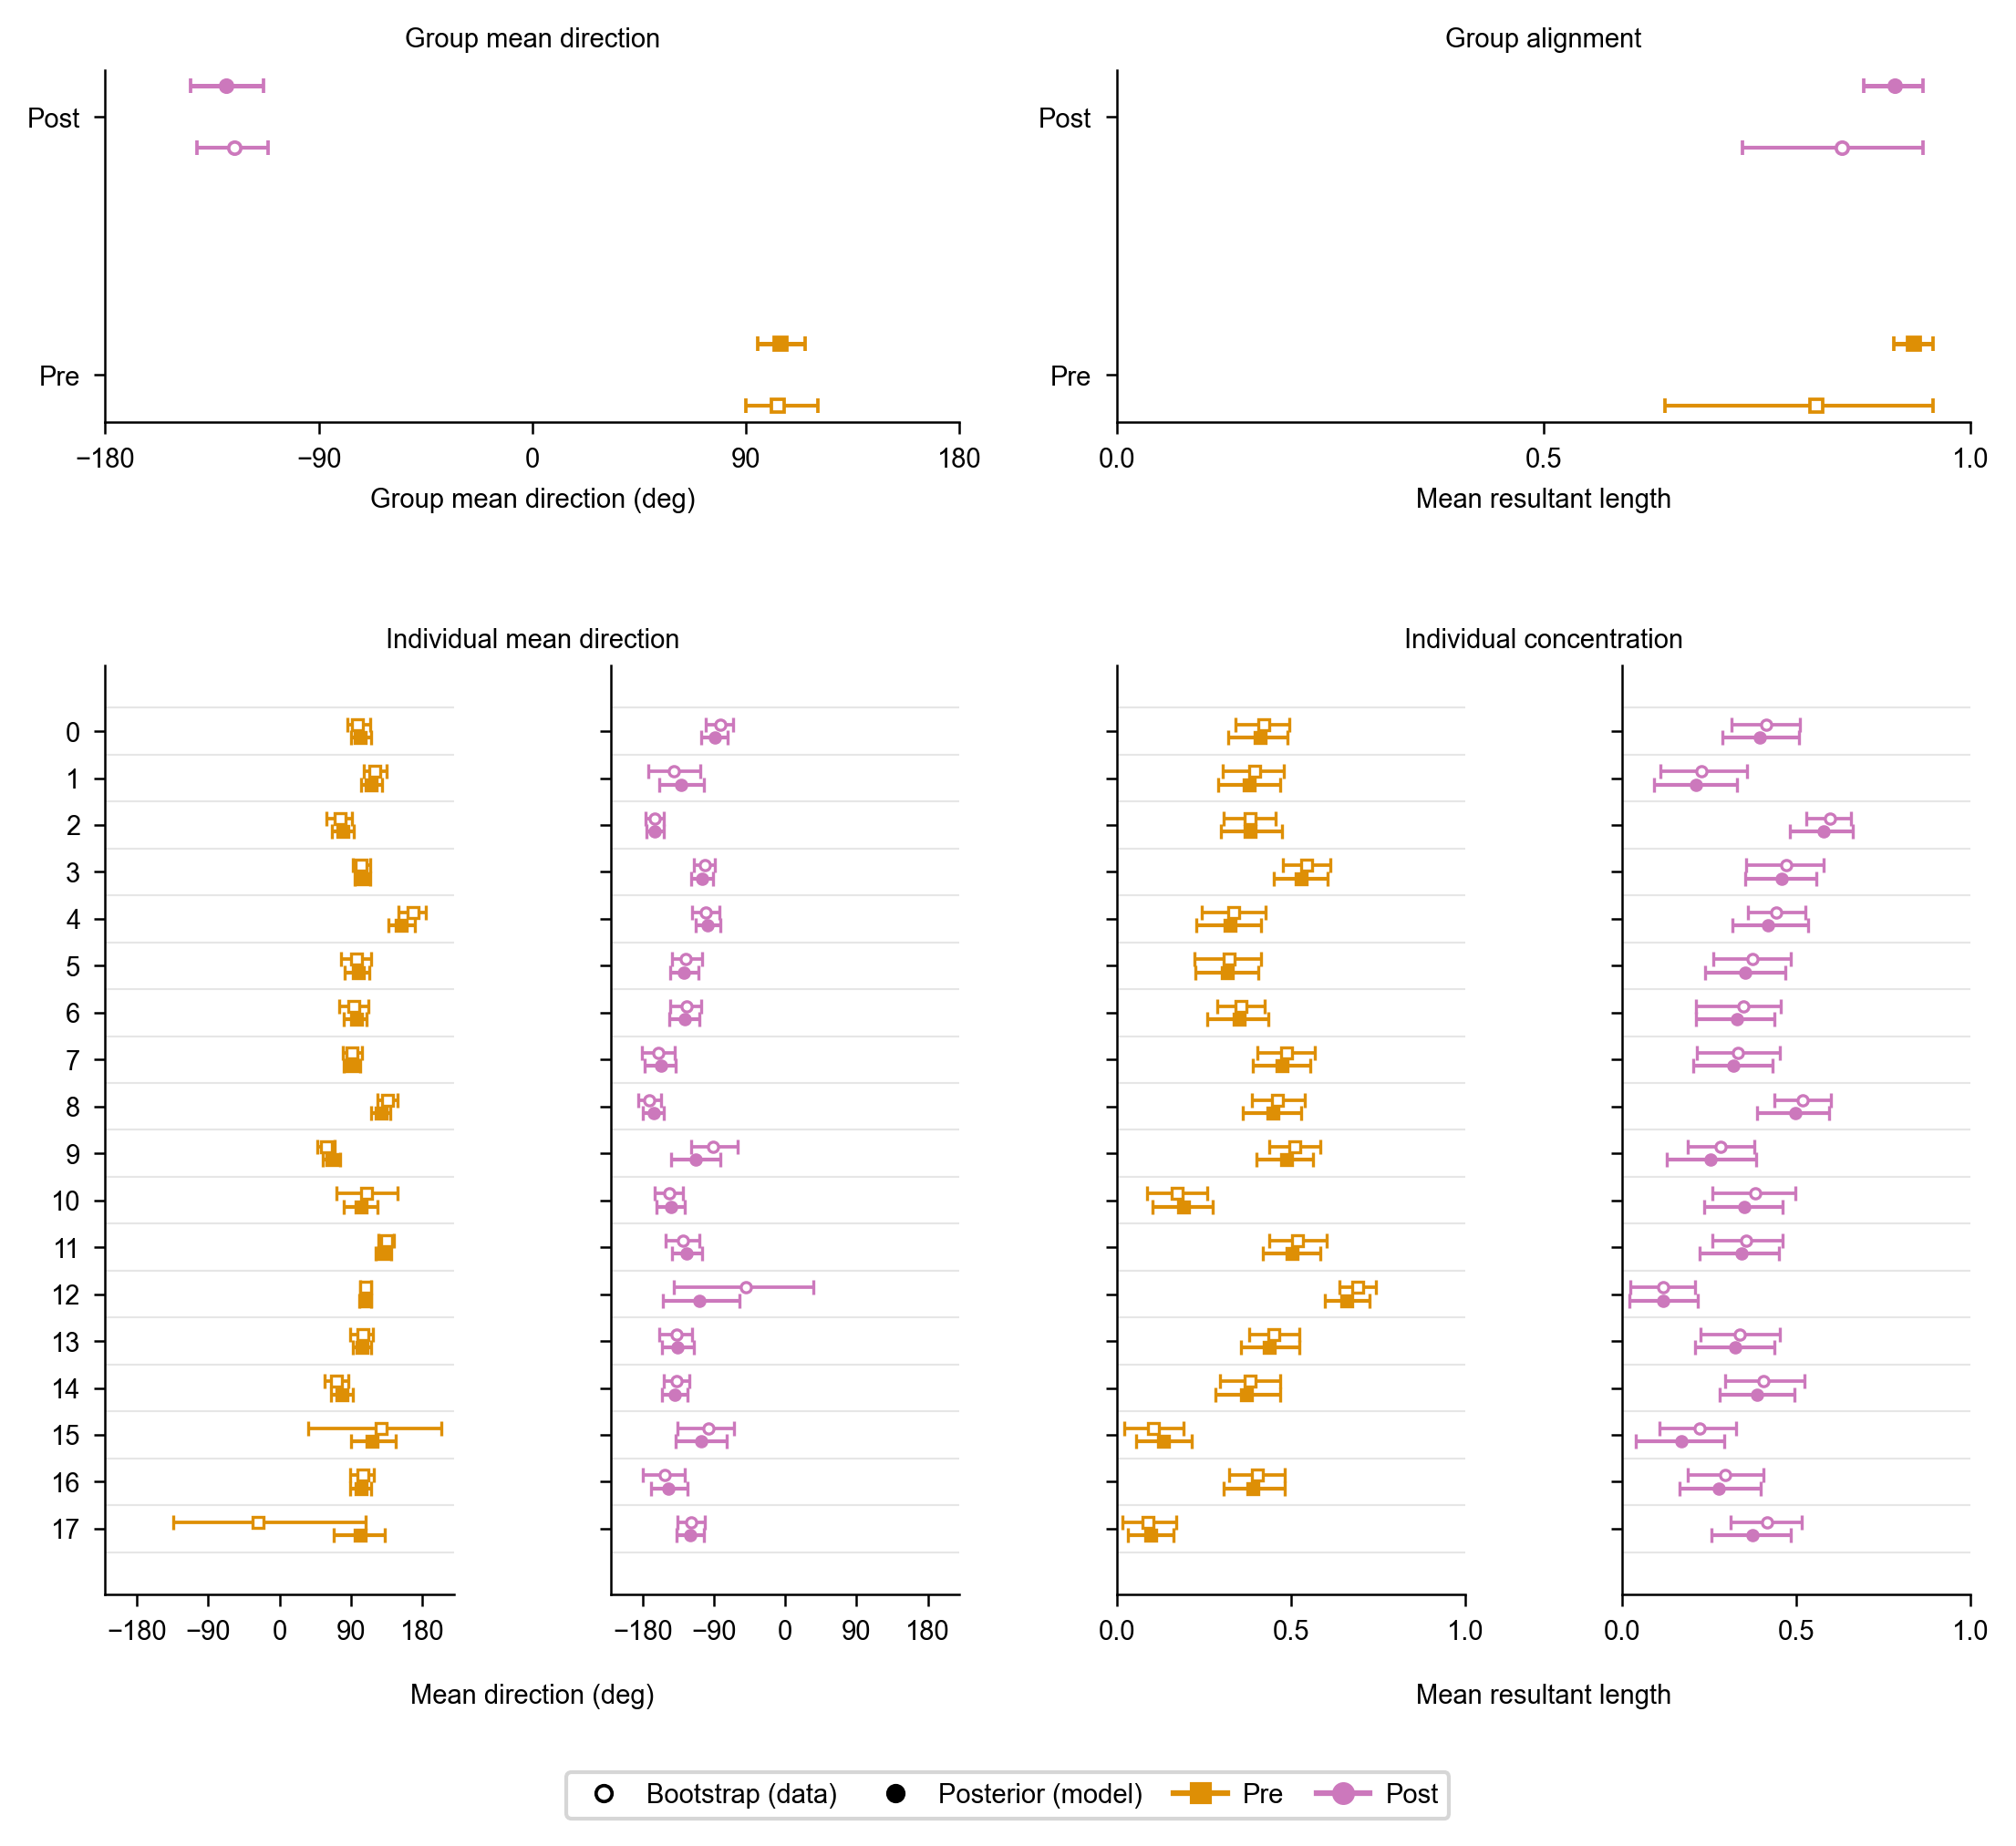

Saved figure to: figures/zebra_ppc_bootstrap_vs_posterior.pdf


In [15]:
# ============================================================
# Zebra supplemental PPC figure — bootstrap (data) vs posterior (model)
# UPDATED:
#   - Top row height reduced a lot (and overall figure height reduced)
#   - Group alignment labels are Pre/Post (NOT baseline/response) and stats match that
#   - Bottom row: 4 panels (mu Pre | mu Post | R Pre | R Post)
#   - Shared x-label per paired bottom panels (label only on left panel of each pair)
#   - Row "boxing" separators: y=j±0.5 in bottom panels
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.special import i0, i1
import seaborn as sns  # needed for colorblind palette

# ----------------------------
# Style (match your other figs)
# ----------------------------
DPI = 300
TICK_LEN = 3
TICK_W   = 0.6
AX_LW    = 0.6

mpl.rcParams.update({
    "figure.dpi": DPI,
    "savefig.dpi": DPI,

    "font.size": 7,
    "axes.labelsize": 7,
    "axes.titlesize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,

    "font.family": "Arial",

    "axes.linewidth": AX_LW,
    "xtick.major.width": TICK_W,
    "ytick.major.width": TICK_W,
    "xtick.major.size": TICK_LEN,
    "ytick.major.size": TICK_LEN,

    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

_cb = sns.color_palette("colorblind")
PRE_COLOR  = _cb[1]  # orange = pre-stimulus
POST_COLOR = _cb[4]  # purple = post-stimulus

# --- marker scheme (match main plot) ---
PRE_MARK  = "s"   # square
POST_MARK = "o"   # circle

def _restore_ticks(ax):
    ax.tick_params(
        axis="both", which="both",
        direction="out",
        bottom=True, top=False, left=True, right=False,
        length=TICK_LEN, width=TICK_W
    )
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")

# ----------------------------
# Helpers
# ----------------------------
def circ_mod(x):
    return (x + np.pi) % (2*np.pi) - np.pi

def circ_mean(theta):
    theta = np.asarray(theta, float)
    z = np.exp(1j * theta).mean()
    return float(circ_mod(np.angle(z)))

def linear_hdi(x, prob=0.95):
    x = np.sort(np.asarray(x, float))
    n = x.size
    if n == 0:
        return np.nan, np.nan
    k = int(np.ceil(prob * n))
    spans = x[k-1:] - x[:n-k+1]
    j = int(np.argmin(spans))
    return float(x[j]), float(x[j + k - 1])

def circ_hdi_centered(samples, prob=0.95):
    a = np.asarray(samples, float)
    m = circ_mean(a)
    d = circ_mod(a - m)
    lo_d, hi_d = linear_hdi(d, prob)
    lo = float(circ_mod(m + lo_d))
    hi = float(circ_mod(m + hi_d))
    return m, lo, hi

def circ_xerr_from_interval(m, lo, hi):
    w_lo = abs(float(circ_mod(m - lo)))
    w_hi = abs(float(circ_mod(hi - m)))
    return np.degrees(w_lo), np.degrees(w_hi)

def A_of_kappa(kappa):
    kappa = np.asarray(kappa, float)
    return i1(kappa) / i0(kappa)

def resultant_length_angles(a, axis=-1):
    a = np.asarray(a, float)
    return np.sqrt(np.mean(np.cos(a), axis=axis)**2 + np.mean(np.sin(a), axis=axis)**2)

def _sorted_tracks(x):
    vals = pd.Series(x).dropna().astype(str).unique().tolist()
    try:
        return sorted(vals, key=lambda v: float(v))
    except Exception:
        return sorted(vals)

def _stack_1d(post, name):
    if name not in post.data_vars:
        raise KeyError(f"Missing posterior variable '{name}'.")
    return post[name].stack(sample=("chain", "draw")).values.astype(float)

# ----------------------------
# Bootstrap routines
# ----------------------------
def hierarchical_bootstrap_group(df, B=1500, seed=123):
    """
    Hierarchical bootstrap (Individuals -> steps) for group-level stats.

    Returns:
      mu_pre, mu_post : group mean directions (angles from individual mean directions)
      R_pre, R_post   : alignment of individual mean directions within condition (Pre/Post)
    """
    rng = np.random.default_rng(seed)
    df = df.copy()
    df["Track"] = df["Track"].astype(str)

    tracks = _sorted_tracks(df["Track"])
    nT = len(tracks)

    pre = {}
    post = {}
    for t in tracks:
        y_pre  = df.loc[(df["Track"] == t) & (df["PostStimulus"] == 0), "HeadingRadians"].dropna().to_numpy(float)
        y_post = df.loc[(df["Track"] == t) & (df["PostStimulus"] == 1), "HeadingRadians"].dropna().to_numpy(float)
        pre[t]  = np.exp(1j * y_pre)  if y_pre.size  else None
        post[t] = np.exp(1j * y_post) if y_post.size else None

    mu_pre_s  = np.empty(B, float)
    mu_post_s = np.empty(B, float)
    R_pre_s   = np.empty(B, float)
    R_post_s  = np.empty(B, float)

    for b in range(B):
        samp_tracks = rng.choice(tracks, size=nT, replace=True)

        u_pre  = []
        u_post = []

        for t in samp_tracks:
            z = pre[t]
            if z is not None:
                idx = rng.integers(0, z.size, size=z.size)
                zbar = z[idx].mean()
                if np.abs(zbar) > 0:
                    u_pre.append(zbar / np.abs(zbar))

            z = post[t]
            if z is not None:
                idx = rng.integers(0, z.size, size=z.size)
                zbar = z[idx].mean()
                if np.abs(zbar) > 0:
                    u_post.append(zbar / np.abs(zbar))

        if len(u_pre) > 0:
            zG = np.mean(u_pre)
            mu_pre_s[b] = circ_mod(np.angle(zG))
            R_pre_s[b]  = np.abs(zG)
        else:
            mu_pre_s[b] = np.nan
            R_pre_s[b]  = np.nan

        if len(u_post) > 0:
            zG = np.mean(u_post)
            mu_post_s[b] = circ_mod(np.angle(zG))
            R_post_s[b]  = np.abs(zG)
        else:
            mu_post_s[b] = np.nan
            R_post_s[b]  = np.nan

    return {
        "mu_pre": mu_pre_s,
        "mu_post": mu_post_s,
        "R_pre": R_pre_s,
        "R_post": R_post_s,
        "tracks": tracks,
    }

def bootstrap_track_condition(y, B=1200, seed=0):
    rng = np.random.default_rng(seed)
    y = np.asarray(y, float)
    if y.size == 0:
        return np.array([]), np.array([])
    z = np.exp(1j * y)
    n = z.size

    mu = np.empty(B, float)
    R  = np.empty(B, float)

    for b in range(B):
        idx = rng.integers(0, n, size=n)
        zbar = z[idx].mean()
        mu[b] = circ_mod(np.angle(zbar))
        R[b]  = np.abs(zbar)

    return mu, R

# ----------------------------
# Data
# ----------------------------
df = df_blocks.copy()
df["Track"] = (
    df["Track"].astype(str)
      .str.replace(r"^observation088-", "", regex=True)
)
tracks = _sorted_tracks(df["Track"])
nT = len(tracks)

# ----------------------------
# Empirical bootstraps
# ----------------------------
B_GROUP = 2000
B_INDIV = 1500

bootG = hierarchical_bootstrap_group(df, B=B_GROUP, seed=123)

boot_mu_pre  = {}
boot_mu_post = {}
boot_R_pre   = {}
boot_R_post  = {}

for j, t in enumerate(tracks):
    y_pre  = df.loc[(df["Track"] == t) & (df["PostStimulus"] == 0), "HeadingRadians"].dropna().to_numpy(float)
    y_post = df.loc[(df["Track"] == t) & (df["PostStimulus"] == 1), "HeadingRadians"].dropna().to_numpy(float)

    mu_b, R_b = bootstrap_track_condition(y_pre,  B=B_INDIV, seed=1000 + j)
    boot_mu_pre[t] = mu_b
    boot_R_pre[t]  = R_b

    mu_b, R_b = bootstrap_track_condition(y_post, B=B_INDIV, seed=2000 + j)
    boot_mu_post[t] = mu_b
    boot_R_post[t]  = R_b

# ----------------------------
# Posterior stats for comparison
# ----------------------------
post = idata.posterior

# fixed effects μ for group mean direction panel
mu_intercept = _stack_1d(post, "Intercept")
mu_post_fx   = _stack_1d(post, "PostStimulus") if "PostStimulus" in post.data_vars else np.zeros_like(mu_intercept)
mu_pop_pre_draw  = circ_mod(mu_intercept)
mu_pop_post_draw = circ_mod(mu_intercept + mu_post_fx)

# Track-level posterior μ and kappa via response_params -> aggregate by Track×Condition
preds = model.predict(idata, kind="response_params", inplace=False)
mu_da    = preds.posterior["mu"]
kappa_da = preds.posterior["kappa"]

obs_dim = [d for d in mu_da.dims if d not in ("chain", "draw")][0]

mu_samps    = mu_da.stack(sample=("chain", "draw")).transpose("sample", obs_dim).values
kappa_samps = kappa_da.stack(sample=("chain", "draw")).transpose("sample", obs_dim).values
S_total, n_obs = mu_samps.shape

track_codes = pd.Categorical(df["Track"], categories=tracks).codes
cond_codes  = df["PostStimulus"].to_numpy(int)
group = track_codes + nT * cond_codes
G = 2 * nT

cnt = np.bincount(group, minlength=G).astype(float)
cnt[cnt == 0] = np.nan

z_mu = np.exp(1j * mu_samps)
sum_re = np.vstack([np.bincount(group, weights=np.real(z_mu[s]), minlength=G) for s in range(S_total)])
sum_im = np.vstack([np.bincount(group, weights=np.imag(z_mu[s]), minlength=G) for s in range(S_total)])
mean_re = sum_re / cnt[None, :]
mean_im = sum_im / cnt[None, :]
mu_group_draw = circ_mod(np.arctan2(mean_im, mean_re))  # (S, G)

R_obsparam = A_of_kappa(kappa_samps)
sum_R = np.vstack([np.bincount(group, weights=R_obsparam[s], minlength=G) for s in range(S_total)])
R_group_draw = sum_R / cnt[None, :]  # (S, G)

mu_pre_draw  = mu_group_draw[:, 0:nT]
mu_post_draw = mu_group_draw[:, nT:2*nT]
R_pre_draw   = R_group_draw[:, 0:nT]
R_post_draw  = R_group_draw[:, nT:2*nT]

# Group alignment (posterior): alignment of individual mean directions per condition
R_group_pre_draw  = resultant_length_angles(mu_pre_draw,  axis=1)
R_group_post_draw = resultant_length_angles(mu_post_draw, axis=1)

# ----------------------------
# Summaries: 95% HDIs
# ----------------------------
# Group mean direction: bootstrap vs posterior fixed effects
muG_pre_m_b,  muG_pre_lo_b,  muG_pre_hi_b  = circ_hdi_centered(bootG["mu_pre"][~np.isnan(bootG["mu_pre"])],   prob=0.95)
muG_post_m_b, muG_post_lo_b, muG_post_hi_b = circ_hdi_centered(bootG["mu_post"][~np.isnan(bootG["mu_post"])], prob=0.95)
muG_pre_m_p,  muG_pre_lo_p,  muG_pre_hi_p  = circ_hdi_centered(mu_pop_pre_draw,  prob=0.95)
muG_post_m_p, muG_post_lo_p, muG_post_hi_p = circ_hdi_centered(mu_pop_post_draw, prob=0.95)

# Group alignment: bootstrap Pre/Post and posterior Pre/Post
R_pre_b = bootG["R_pre"][~np.isnan(bootG["R_pre"])]
R_post_b = bootG["R_post"][~np.isnan(bootG["R_post"])]

R_pre_m_b = float(np.nanmean(R_pre_b)) if R_pre_b.size else np.nan
R_pre_lo_b, R_pre_hi_b = linear_hdi(R_pre_b, prob=0.95) if R_pre_b.size else (np.nan, np.nan)

R_post_m_b = float(np.nanmean(R_post_b)) if R_post_b.size else np.nan
R_post_lo_b, R_post_hi_b = linear_hdi(R_post_b, prob=0.95) if R_post_b.size else (np.nan, np.nan)

R_pre_m_p = float(np.mean(R_group_pre_draw))
R_pre_lo_p, R_pre_hi_p = linear_hdi(R_group_pre_draw, prob=0.95)

R_post_m_p = float(np.mean(R_group_post_draw))
R_post_lo_p, R_post_hi_p = linear_hdi(R_group_post_draw, prob=0.95)

# Individual-level tables (μ and R)
track_mu_rows = []
track_R_rows  = []
for j, t in enumerate(tracks):
    # bootstrap μ
    mu_b = boot_mu_pre[t]
    if mu_b.size:
        m, lo, hi = circ_hdi_centered(mu_b, prob=0.95)
        track_mu_rows.append(("Pre", t, m, lo, hi, "bootstrap"))
    mu_b = boot_mu_post[t]
    if mu_b.size:
        m, lo, hi = circ_hdi_centered(mu_b, prob=0.95)
        track_mu_rows.append(("Post", t, m, lo, hi, "bootstrap"))

    # posterior μ
    m, lo, hi = circ_hdi_centered(mu_pre_draw[:, j], prob=0.95)
    track_mu_rows.append(("Pre", t, m, lo, hi, "posterior"))
    m, lo, hi = circ_hdi_centered(mu_post_draw[:, j], prob=0.95)
    track_mu_rows.append(("Post", t, m, lo, hi, "posterior"))

    # bootstrap R
    Rb = boot_R_pre[t]
    if Rb.size:
        track_R_rows.append(("Pre", t, float(np.mean(Rb)), *linear_hdi(Rb, prob=0.95), "bootstrap"))
    Rb = boot_R_post[t]
    if Rb.size:
        track_R_rows.append(("Post", t, float(np.mean(Rb)), *linear_hdi(Rb, prob=0.95), "bootstrap"))

    # posterior R
    Rp = R_pre_draw[:, j]
    track_R_rows.append(("Pre", t, float(np.mean(Rp)), *linear_hdi(Rp, prob=0.95), "posterior"))
    Rp = R_post_draw[:, j]
    track_R_rows.append(("Post", t, float(np.mean(Rp)), *linear_hdi(Rp, prob=0.95), "posterior"))

mu_tbl = pd.DataFrame(track_mu_rows, columns=["Condition","Track","mean","low","high","Source"])
R_tbl  = pd.DataFrame(track_R_rows,  columns=["Condition","Track","mean","low","high","Source"])

# ----------------------------
# Plot: 2 rows × 4 cols
#   Top: 2 panels spanning 2 columns each
#   Bottom: 4 panels (mu Pre | mu Post | R Pre | R Post)
# ----------------------------
fig_w = 8.8

# smaller overall height (was ~0.45*nT + 3.0)
fig_h = max(3.4, 0.28 * nT + 2.2)

# smaller top row height ratio
bottom_ratio = max(1.2, 0.55 + 0.05 * nT)

fig = plt.figure(figsize=(fig_w, fig_h), dpi=DPI)
gs = fig.add_gridspec(
    2, 4,
    height_ratios=[0.55, bottom_ratio],
    wspace=0.45,
    hspace=0.38
)

ax_g_mu   = fig.add_subplot(gs[0, 0:2])
ax_g_R    = fig.add_subplot(gs[0, 2:4])

ax_mu_pre  = fig.add_subplot(gs[1, 0])
ax_mu_post = fig.add_subplot(gs[1, 1])
ax_R_pre   = fig.add_subplot(gs[1, 2])
ax_R_post  = fig.add_subplot(gs[1, 3])

y_track = np.arange(nT, dtype=float)
dy_src = 0.14

def add_row_boxes(ax):
    ax.set_axisbelow(True)
    for y in np.arange(-0.5, nT, 1.0):
        ax.axhline(y, color="0.90", lw=0.5, zorder=0)

for ax in (ax_mu_pre, ax_mu_post, ax_R_pre, ax_R_post):
    add_row_boxes(ax)

# ---- (1) Group mean direction (deg)
y_base = np.array([0.0, 1.0])  # Pre, Post
y_boot = y_base - 0.12
y_post = y_base + 0.12

def _plot_group_mu_point(ax, m, lo, hi, y, color, marker, filled):
    wlo, whi = circ_xerr_from_interval(m, lo, hi)
    ax.errorbar(
        np.degrees(m), y,
        xerr=np.array([[wlo], [whi]]),
        fmt=marker,
        color=color, ecolor=color,
        capsize=2, ms=3.2,
        mfc=(color if filled else "white"),
        mec=color, mew=0.9,
        lw=(1.2 if filled else 1.0),
        zorder=3
    )

_plot_group_mu_point(ax_g_mu, muG_pre_m_b,  muG_pre_lo_b,  muG_pre_hi_b,  y_boot[0], PRE_COLOR,  PRE_MARK,  filled=False)
_plot_group_mu_point(ax_g_mu, muG_pre_m_p,  muG_pre_lo_p,  muG_pre_hi_p,  y_post[0], PRE_COLOR,  PRE_MARK,  filled=True)
_plot_group_mu_point(ax_g_mu, muG_post_m_b, muG_post_lo_b, muG_post_hi_b, y_boot[1], POST_COLOR, POST_MARK, filled=False)
_plot_group_mu_point(ax_g_mu, muG_post_m_p, muG_post_lo_p, muG_post_hi_p, y_post[1], POST_COLOR, POST_MARK, filled=True)

ax_g_mu.set_yticks(y_base)
ax_g_mu.set_yticklabels(["Pre", "Post"])
ax_g_mu.set_xlim(-180, 180)
ax_g_mu.set_xticks([-180, -90, 0, 90, 180])
ax_g_mu.set_xlabel("Group mean direction (deg)")
ax_g_mu.set_title("Group mean direction")
ax_g_mu.spines["top"].set_visible(False)
ax_g_mu.spines["right"].set_visible(False)
_restore_ticks(ax_g_mu)

# ---- (2) Group alignment (R): Pre/Post (not baseline/response)
rows = [
    ("Pre",  PRE_COLOR,  PRE_MARK,  R_pre_m_b,  R_pre_lo_b,  R_pre_hi_b,  R_pre_m_p,  R_pre_lo_p,  R_pre_hi_p),
    ("Post", POST_COLOR, POST_MARK, R_post_m_b, R_post_lo_b, R_post_hi_b, R_post_m_p, R_post_lo_p, R_post_hi_p),
]

y_base2 = np.arange(len(rows), dtype=float)
y_boot2 = y_base2 - 0.12
y_post2 = y_base2 + 0.12

for i, (lab, col, mark, mb, lob, hib, mp, lop, hip) in enumerate(rows):
    if np.isfinite(mb):
        ax_g_R.errorbar(
            mb, y_boot2[i],
            xerr=np.array([[mb - lob], [hib - mb]]),
            fmt=mark, color=col, ecolor=col,
            capsize=2, ms=3.2, mfc="white", mec=col, mew=0.9, lw=1.0, zorder=3
        )
    if np.isfinite(mp):
        ax_g_R.errorbar(
            mp, y_post2[i],
            xerr=np.array([[mp - lop], [hip - mp]]),
            fmt=mark, color=col, ecolor=col,
            capsize=2, ms=3.2, mfc=col, mec=col, mew=0.9, lw=1.2, zorder=3
        )

ax_g_R.set_yticks(y_base2)
ax_g_R.set_yticklabels([r[0] for r in rows])
ax_g_R.set_xlim(0, 1.0)
ax_g_R.set_xticks([0.0, 0.5, 1.0])
ax_g_R.set_xlabel("Mean resultant length")
ax_g_R.set_title("Group alignment")
ax_g_R.spines["top"].set_visible(False)
ax_g_R.spines["right"].set_visible(False)
_restore_ticks(ax_g_R)

# ---- Bottom plotting helpers: one condition per axis
def _plot_mu_condition(ax, cond, cond_color, cond_marker):
    sub_b = mu_tbl[(mu_tbl["Condition"] == cond) & (mu_tbl["Source"] == "bootstrap")].set_index("Track")
    sub_p = mu_tbl[(mu_tbl["Condition"] == cond) & (mu_tbl["Source"] == "posterior")].set_index("Track")

    for j, t in enumerate(tracks):
        if t in sub_b.index:
            m  = float(sub_b.loc[t, "mean"])
            lo = float(sub_b.loc[t, "low"])
            hi = float(sub_b.loc[t, "high"])
            wlo, whi = circ_xerr_from_interval(m, lo, hi)
            ax.errorbar(
                np.degrees(m), y_track[j] - dy_src,
                xerr=np.array([[wlo], [whi]]),
                fmt=cond_marker, color=cond_color, ecolor=cond_color,
                capsize=2, ms=2.7, mfc="white", mec=cond_color, mew=0.8, lw=0.9, zorder=3
            )
        if t in sub_p.index:
            m  = float(sub_p.loc[t, "mean"])
            lo = float(sub_p.loc[t, "low"])
            hi = float(sub_p.loc[t, "high"])
            wlo, whi = circ_xerr_from_interval(m, lo, hi)
            ax.errorbar(
                np.degrees(m), y_track[j] + dy_src,
                xerr=np.array([[wlo], [whi]]),
                fmt=cond_marker, color=cond_color, ecolor=cond_color,
                capsize=2, ms=2.7, mfc=cond_color, mec=cond_color, mew=0.8, lw=1.0, zorder=3
            )

def _plot_R_condition(ax, cond, cond_color, cond_marker):
    sub_b = R_tbl[(R_tbl["Condition"] == cond) & (R_tbl["Source"] == "bootstrap")].set_index("Track")
    sub_p = R_tbl[(R_tbl["Condition"] == cond) & (R_tbl["Source"] == "posterior")].set_index("Track")

    for j, t in enumerate(tracks):
        if t in sub_b.index:
            m  = float(sub_b.loc[t, "mean"])
            lo = float(sub_b.loc[t, "low"])
            hi = float(sub_b.loc[t, "high"])
            ax.errorbar(
                m, y_track[j] - dy_src,
                xerr=np.array([[m - lo], [hi - m]]),
                fmt=cond_marker, color=cond_color, ecolor=cond_color,
                capsize=2, ms=2.7, mfc="white", mec=cond_color, mew=0.8, lw=0.9, zorder=3
            )
        if t in sub_p.index:
            m  = float(sub_p.loc[t, "mean"])
            lo = float(sub_p.loc[t, "low"])
            hi = float(sub_p.loc[t, "high"])
            ax.errorbar(
                m, y_track[j] + dy_src,
                xerr=np.array([[m - lo], [hi - m]]),
                fmt=cond_marker, color=cond_color, ecolor=cond_color,
                capsize=2, ms=2.7, mfc=cond_color, mec=cond_color, mew=0.8, lw=1.0, zorder=3
            )

# ---- Bottom panels
_plot_mu_condition(ax_mu_pre,  "Pre",  PRE_COLOR,  PRE_MARK)
_plot_mu_condition(ax_mu_post, "Post", POST_COLOR, POST_MARK)
_plot_R_condition(ax_R_pre,    "Pre",  PRE_COLOR,  PRE_MARK)
_plot_R_condition(ax_R_post,   "Post", POST_COLOR, POST_MARK)

# format bottom axes
for ax in (ax_mu_pre, ax_mu_post, ax_R_pre, ax_R_post):
    ax.set_yticks(y_track)
    ax.invert_yaxis()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    _restore_ticks(ax)

# y tick labels only on first bottom axis
ax_mu_pre.set_yticklabels(tracks)
ax_mu_post.set_yticklabels([""] * nT)
ax_R_pre.set_yticklabels([""] * nT)
ax_R_post.set_yticklabels([""] * nT)

# x scales
ax_mu_pre.set_xlim(-220, 220)
ax_mu_post.set_xlim(-220, 220)
ax_mu_pre.set_xticks([-180, -90, 0, 90, 180])
ax_mu_post.set_xticks([-180, -90, 0, 90, 180])

ax_R_pre.set_xlim(0, 1.0)
ax_R_post.set_xlim(0, 1.0)
ax_R_pre.set_xticks([0.0, 0.5, 1.0])
ax_R_post.set_xticks([0.0, 0.5, 1.0])

ax_mu_pre.set_xlabel("Mean direction (deg)")
ax_R_pre.set_xlabel("Mean resultant length")

def _pair_xlabel(fig, ax_left, ax_right, text, y_pad=0.045):
    """Center an xlabel between two axes using figure coordinates."""
    pL = ax_left.get_position()
    pR = ax_right.get_position()
    x = 0.5 * (pL.x0 + pR.x1)
    y = min(pL.y0, pR.y0) - y_pad
    fig.text(x, y, text, ha="center", va="top")

# remove axis-level xlabels (so you don't get duplicates)
ax_mu_pre.set_xlabel("")
ax_mu_post.set_xlabel("")
ax_R_pre.set_xlabel("")
ax_R_post.set_xlabel("")

# centered pair xlabels
_pair_xlabel(fig, ax_mu_pre, ax_mu_post, "Mean direction (deg)", y_pad=0.045)
_pair_xlabel(fig, ax_R_pre,  ax_R_post,  "Mean resultant length", y_pad=0.045)

# ---- Pair labels above bottom panels (no redundant subplot titles)
def _pair_label(ax_left, ax_right, text, y_pad=0.006):
    pL = ax_left.get_position()
    pR = ax_right.get_position()
    x = 0.5 * (pL.x0 + pR.x1)
    y = max(pL.y1, pR.y1) + y_pad
    fig.text(x, y, text, ha="center", va="bottom")

_pair_label(ax_mu_pre, ax_mu_post, "Individual mean direction")
_pair_label(ax_R_pre,  ax_R_post,  "Individual concentration")

# ----------------------------
# Legend (outside, no overlap)
# ----------------------------
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0],[0], marker="o", linestyle="none", color="k",
           markerfacecolor="white", markeredgecolor="k", markeredgewidth=0.9,
           markersize=4.2, label="Bootstrap (data)"),
    Line2D([0],[0], marker="o", linestyle="none", color="k",
           markerfacecolor="k", markeredgecolor="k", markeredgewidth=0.9,
           markersize=4.2, label="Posterior (model)"),
    Line2D([0],[0], color=PRE_COLOR,  lw=1.5, marker=PRE_MARK,  markersize=5, label="Pre"),
    Line2D([0],[0], color=POST_COLOR, lw=1.5, marker=POST_MARK, markersize=5, label="Post"),
]
fig.legend(
    handles=legend_handles,
    loc="lower center",
    ncol=4,
    frameon=True,
    bbox_to_anchor=(0.5, -0.01),
    columnspacing=1.2,
    handletextpad=0.6
)

# ----------------------------
# Save
# ----------------------------
out_dir = "figures"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "zebra_ppc_bootstrap_vs_posterior.pdf")
fig.savefig(out_path, dpi=DPI, bbox_inches="tight", pad_inches=0.01)
plt.show()

print(f"Saved figure to: {out_path}")
